In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical platinumprice data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the platinum price:

platinum = pd.read_csv(
    Path("platinum.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)

platinum.head()

Close Volume    Open    High     Low
Date                                             
2014-12-15  1214.9   1233  1210.0  1214.5  1206.3
2014-12-16  1214.9    170  1210.0  1214.5  1209.4
2014-12-17  1199.5  14688  1201.3  1206.6  1189.2
2014-12-18  1197.1  14449  1194.5  1214.9  1193.1
2014-12-19  1197.0  13002  1201.4  1204.0  1195.4

In [3]:
# Trim the dataset to begin on December 15th, 2014
platinum = platinum.loc["2014-12-15":, :]
platinum.head(500)


Close Volume    Open    High     Low
Date                                             
2014-12-15  1214.9   1233  1210.0  1214.5  1206.3
2014-12-16  1214.9    170  1210.0  1214.5  1209.4
2014-12-17  1199.5  14688  1201.3  1206.6  1189.2
2014-12-18  1197.1  14449  1194.5  1214.9  1193.1
2014-12-19  1197.0  13002  1201.4  1204.0  1195.4
...            ...    ...     ...     ...     ...
2016-12-01   911.3  15929   912.8   918.2   898.5
2016-12-02   932.7  15759   934.6   935.7   914.2
2016-12-05   938.6  14033   931.7   941.8   924.7
2016-12-06   935.7  16377   938.3   953.0   934.1
2016-12-07   943.2  15850   935.2   950.9   928.0

[500 rows x 5 columns]

 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Close/Last" price. Do you see any patterns, long-term and/or short?

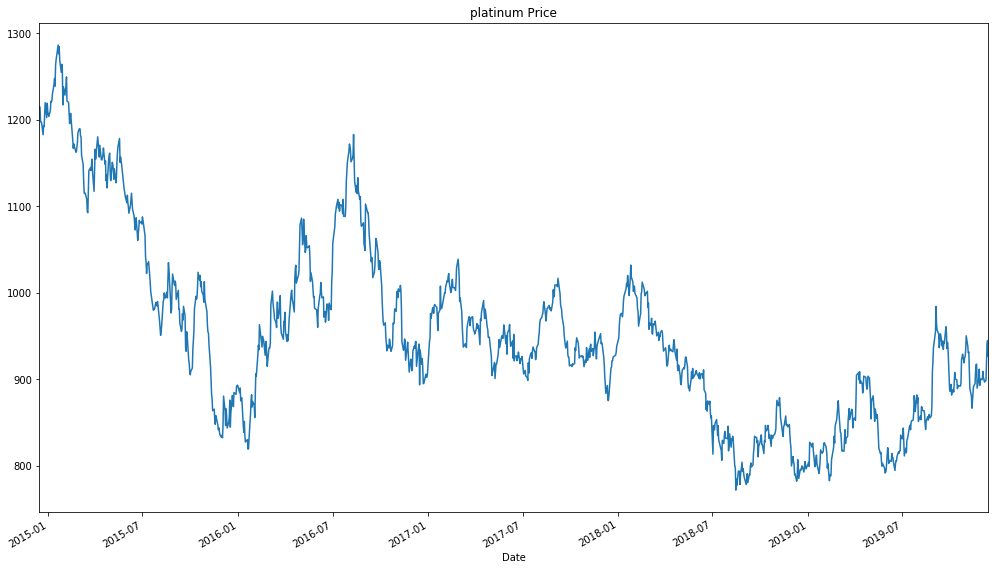

In [4]:
# Plot just the "Close" column from the dataframe:
platinum['Close'].plot(figsize=(17, 10), title="platinum Price")

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the platinum prices. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Close" price into two separate series:
platinum_noise, platinum_trend = sm.tsa.filters.hpfilter(platinum['Close'])

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
platinum_decomp = platinum[["Close"]].copy()
platinum_decomp["noise"] = platinum_noise
platinum_decomp["trend"] = platinum_trend
platinum_decomp.head()

Close      noise        trend
Date                                      
2014-12-15  1214.9  21.342691  1193.557309
2014-12-16  1214.9  19.304856  1195.595144
2014-12-17  1199.5   1.853682  1197.646318
2014-12-18  1197.1  -2.636236  1199.736236
2014-12-19  1197.0  -4.891461  1201.891461

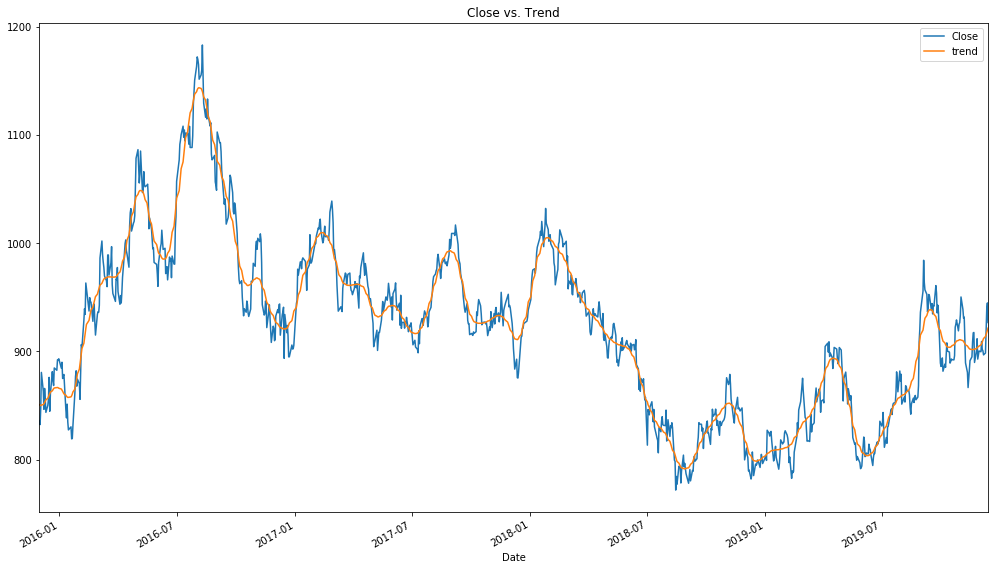

In [7]:
# Plot the Settle Price vs. the Trend
platinum_decomp[["Close", "trend"]]["2015-12-01":].plot(figsize=(17, 10), title="Close vs. Trend")

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

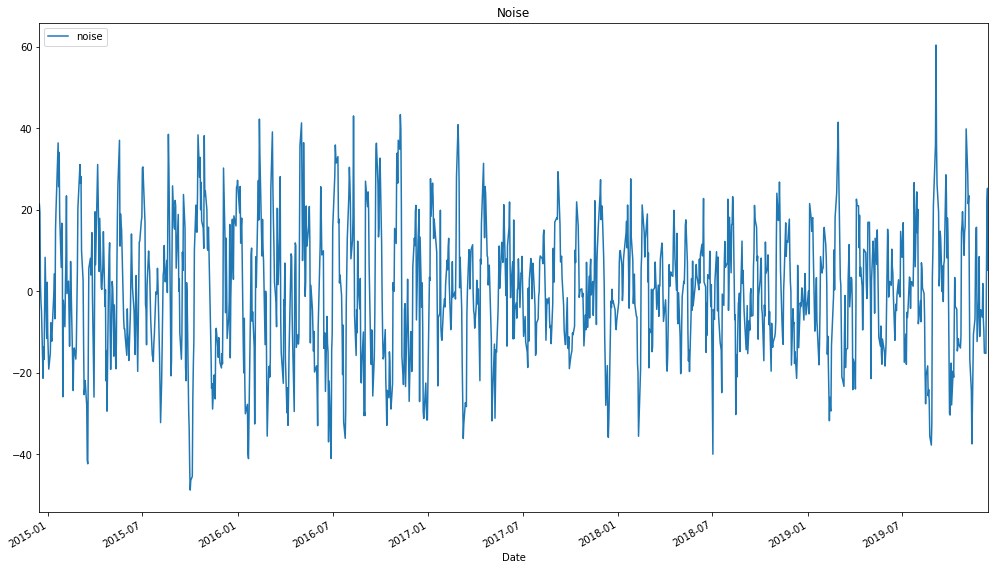

In [8]:
# Plot the Settle Noise
platinum_decomp[["noise"]].plot(figsize=(17, 10), title="Noise")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (platinum[["Close"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

Close
Date                
2019-12-09  0.189563
2019-12-10  2.448525
2019-12-11  2.064096
2019-12-12  0.564130
2019-12-13 -1.915749

In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [11]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1259
Model:                     ARMA(2, 1)   Log Likelihood               -2106.997
Method:                       css-mle   S.D. of innovations              1.290
Date:                Fri, 20 Dec 2019   AIC                           4223.995
Time:                        21:12:13   BIC                           4249.685
Sample:                             0   HQIC                          4233.649
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0131      0.036     -0.362      0.717      -0.084       0.058
ar.L1.y       -0.7313      0.205     -3.563      0.000      -1.134      -0.329
ar.L2.y        0.0217      0.034      0.648      0.517      -0.044       0.087
ma.L1.y        0.7054      0.204      3.462      0.001       0.306       1.105
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3160           +0.0000j            1.3160            0.5000
AR.2           34.9656           +0.0000j           34.9656            0.0000
MA.1           -1.4177           +0.0000j            1.4177            0.5000
-----------------------------------------------------------------------------
"""

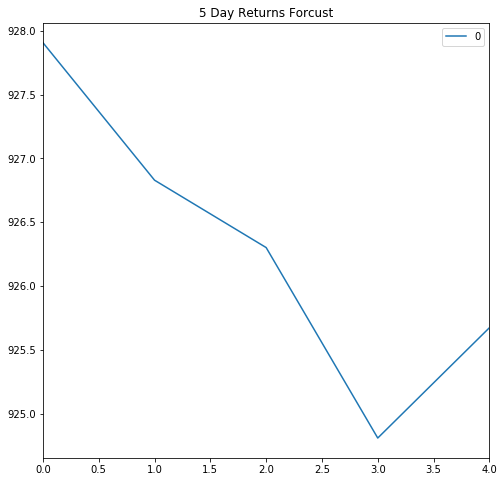

In [35]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(figsize=(8, 8), title="5 Day Returns Forcust")

## Question:

#### Based on the p-value, is the model a good fit?

## Answer:

#### Based on the p-value, the model is not a good fit.

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(platinum["Close"], order=(5, 1, 1))


# Fit the model
results = model.fit()

C:\Users\armen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\armen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1259
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -4938.774
Method:                       css-mle   S.D. of innovations             12.229
Date:                Fri, 20 Dec 2019   AIC                           9893.549
Time:                        21:12:14   BIC                           9934.653
Sample:                             1   HQIC                          9908.996
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2288      0.353     -0.649      0.516      -0.920       0.462
ar.L1.D.Close    -0.1468      0.347     -0.424      0.672      -0.826       0.532
ar.L2.D.Close     0.0368      0.029      1.261      0.207      -0.020       0.094
ar.L3.D.Close    -0.0059      0.032     -0.188      0.851      -0.068       0.056
ar.L4.D.Close     0.0565      0.029      1.960      0.050   -2.47e-06       0.113
ar.L5.D.Close    -0.0466      0.036     -1.278      0.201      -0.118       0.025
ma.L1.D.Close     0.1315      0.346      0.380      0.704      -0.547       0.810
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5163           -0.0000j            1.5163           -0.5000
AR.2           -0.4631           -1.7079j            1.7696           -0.2921
AR.3           -0.4631           +1.7079j            1.7696            0.2921
AR.4            1.8285           -1.0864j            2.1269           -0.0853
AR.5            1.8285           +1.0864j            2.1269            0.0853
MA.1           -7.6048           +0.0000j            7.6048            0.5000
-----------------------------------------------------------------------------
"""

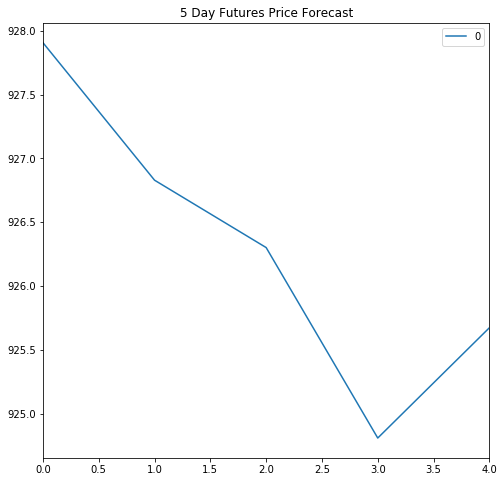

In [33]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(figsize=(8, 8), title="5 Day Futures Price Forecast")

### What does the model forecast will happen to the Japanese Yen in the near term?

### Based on model forcast the Japanese Yen will go up in value

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
import arch as arch
from arch import arch_model

In [17]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1, rescale=False)

# Fit the model
res = model.fit(disp="off")

In [18]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2097.30
Distribution:                  Normal   AIC:                           4202.59
Method:            Maximum Likelihood   BIC:                           4223.15
                                        No. Observations:                 1259
Date:                Fri, Dec 20 2019   Df Residuals:                     1255
Time:                        21:12:15   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0195  1.531e-02      1.275      0.202 [-1.048e-02,4.954e-02]
alpha[1]       0.0185  2.185e-02      0.845      0.398 [-2.435e-02,6.129e-02]
alpha[2]   3.5766e-11  2.242e-02  1.595e-09      1.000 [-4.395e-02,4.395e-02]
beta[1]        0.9703  1.470e-02     66.016      0.000      [  0.941,  0.999]
=============================================================================

Covariance estimator: robust
"""

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-12-13'

In [28]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [29]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.tail()

h.1        h.2        h.3        h.4        h.5
Date                                                            
2019-12-13  21.37698  21.371498  21.366077  21.360715  21.355413

In [30]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date  2019-12-13
h.1    21.376980
h.2    21.371498
h.3    21.366077
h.4    21.360715
h.5    21.355413

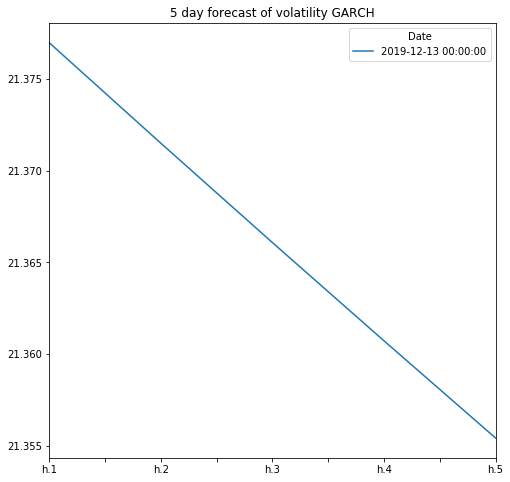

In [31]:
# Plot the final forecast
final.plot(figsize=(8, 8), title="5 day forecast of volatility GARCH")

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

2. Is the risk of the yen expected to increase or decrease?

3. Based on the model evaluation, would you feel confident in using these models for trading?

1. Based on time series analysis I would by the yen now.

2. Yes, the risk expected to increase.

3. Based on the model evaluation, I feel confident uding only GARCH model for trading. ARMA and ARIMA are not good fit.